In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import random
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPool2D

In [2]:
plt.figure(figsize=(12,12))
path = "imagesok"


<Figure size 1200x1200 with 0 Axes>

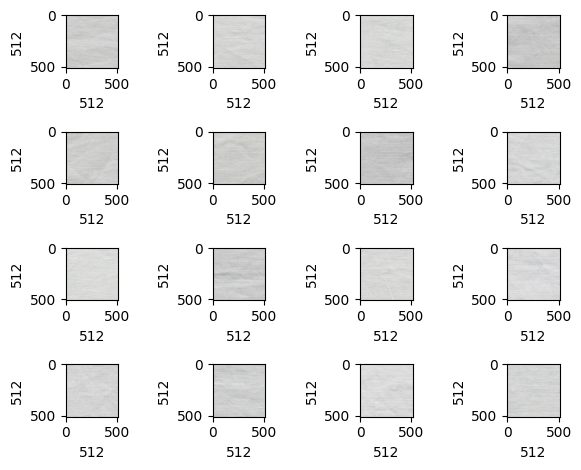

In [3]:
for i in range(1,17):
    plt.subplot(4,4,i)
    plt.tight_layout()
    rand_img = imread(path +'/' + random.choice(sorted(os.listdir(path))))
    plt.imshow(rand_img)
    plt.xlabel(rand_img.shape[1], fontsize = 10)
    plt.ylabel(rand_img.shape[0], fontsize = 10)

In [4]:
good = []
goodlabel = []
imagesok = "imagesok"
image_path = os.listdir(imagesok)
for x in image_path:
    img = Image.open(imagesok + '/' + x)
    img = img.resize((128,128))
    good.append(img)
    goodlabel.append(x)

In [5]:
goodnp = np.array(good)
goodnp = goodnp/255

In [6]:
bad = []
badlabel = []
imagesnotok = "imagesnotok"
image_path = os.listdir(imagesnotok)
for x in image_path:
    img = Image.open(imagesnotok + '/' + x)
    img = img.resize((128,128))
    bad.append(img)
    badlabel.append(x)

In [7]:
badnp = np.array(bad)
badnp = badnp/255

In [8]:
badlabel = np.array(badlabel)
goodlabel = np.array(goodlabel)

In [9]:
file_path = 'datafile.xlsx'  # Update this path as necessary
df = pd.read_excel(file_path, skiprows=1, header=0)
df['Image Paths'] = df['Image Paths'].str.replace('.png', '.jpg', regex=False)

In [10]:
df.columns = ['Index', 'Value', 'Image Path']

In [11]:
df.head()

,Index,Value,Image Path
0,000001.jpg,0,imagesok/000001.jpg
1,000002.jpg,0,imagesok/000002.jpg
2,000003.jpg,0,imagesok/000003.jpg
3,000004.jpg,0,imagesok/000004.jpg
4,000005.jpg,0,imagesok/000005.jpg


In [14]:
from sklearn.model_selection import StratifiedShuffleSplit
strat_train_set, strat_test_set = train_test_split(df, test_size = 0.2 , stratify=df["Value"], random_state = 42)

In [15]:
from keras.preprocessing.image import load_img, img_to_array

# Function to load and preprocess images
def load_and_preprocess_images(dataframe):
    images = []
    labels = []

    for index, row in dataframe.iterrows():
        img_path = row['Image Path']
        img = load_img(img_path, target_size=(128, 128))  # Resize images
        img_array = img_to_array(img) / 255.0  # Convert to array and normalize
        images.append(img_array)
        labels.append(row['Value'])

    return np.array(images), np.array(labels)

# Load images for training and testing sets
X_train, y_train = load_and_preprocess_images(strat_train_set)
X_test, y_test = load_and_preprocess_images(strat_test_set)


In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPool2D

# Define the model
model = Sequential()
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(128, 128, 3)))  # Input shape (height, width, channels)
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))  

c:\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [18]:

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)

Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 22s 234ms/step - accuracy: 0.7031 - loss: 1.0857 - val_accuracy: 0.7504 - val_loss: 0.6731
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 21s 233ms/step - accuracy: 0.7484 - loss: 0.5868 - val_accuracy: 0.7504 - val_loss: 0.6099
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 21s 234ms/step - accuracy: 0.7557 - loss: 0.5680 - val_accuracy: 0.7504 - val_loss: 0.6022
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 21s 232ms/step - accuracy: 0.7471 - loss: 0.5613 - val_accuracy: 0.7504 - val_loss: 0.6516
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 21s 230ms/step - accuracy: 0.7537 - loss: 0.5865 - val_accuracy: 0.7504 - val_loss: 0.5922
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 21s 234ms/step - accuracy: 0.7522 - loss: 0.5639 - val_accuracy: 0.7504 - val_loss: 0.5831
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 23s 254ms/step - accuracy: 0.7368 - loss: 0.5840 - val_accuracy: 0.7504 - val_loss: 0.5534
Epoch 8/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 26s 289ms/step - accuracy: 0.7399 - loss: 0.5882 - val_accu

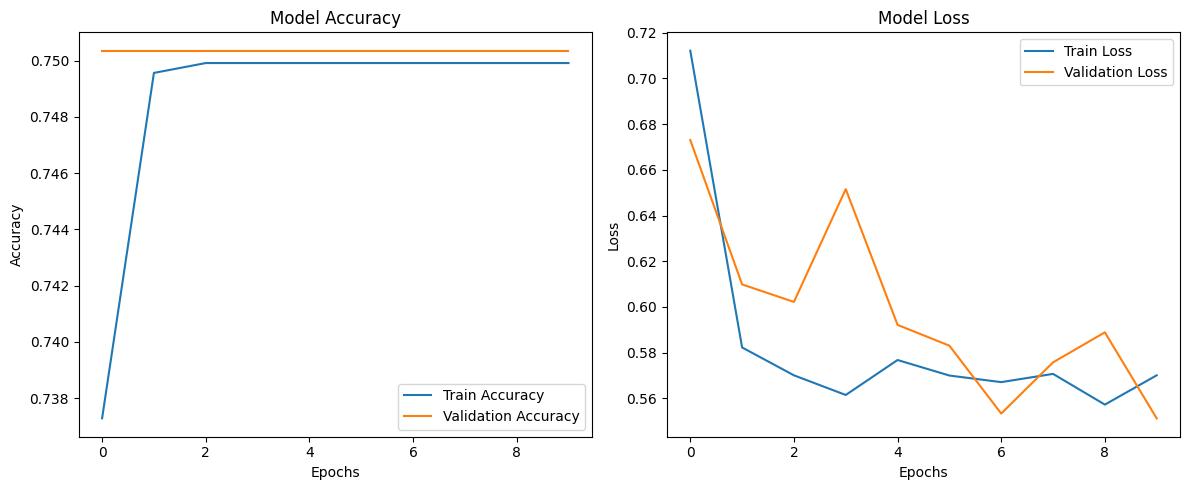

In [19]:
import matplotlib.pyplot as plt

# Function to plot training history
def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

# Call the function to plot the results
plot_training_history(history)
